In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "TRB_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-DC4Balance-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-Myositis-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-MOMA-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-AB-ADA-TRB_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20221003-DataSheet-RUN49.csv"
run = "run49"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run49-similarity-TRB_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,BP-T017-2-Tu_S1,ACGTACGT,CASSIFGNTEAFFG,652,18,TRBV19,TRBJ1-1,0,0.000000,10.198655,5.787781
1,BP-T017-2-Tu_S1,ACGTACGT,CASSIIPGGELFFG,378,9,TRBV12-3+TRBV12-4,TRBJ2-2,379,1.002646,5.912717,2.893891
2,BP-T017-2-Tu_S1,ACGTACGT,CSVEDRKTNTEAFFG,261,8,TRBV29-1,TRBJ1-1,513,1.965517,4.082590,2.572347
3,BP-T017-2-Tu_S1,ACGTACGT,CASSNVGPNTEAFFG,205,6,TRBV18,TRBJ1-1,0,0.000000,3.206632,1.929260
4,BP-T017-2-Tu_S1,ACGTACGT,CASMETGPYSNQPQHFG,204,2,TRBV6-6,TRBJ1-5,205,1.004902,3.190990,0.643087


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
869528,T19-00509-T2_S165,CATSESVNTGELFFG,2536,1190,2533,0.998817,10.508432,11.733386
868938,T19-00509-T2_S165,CASSRTGDSSYEQYFG,919,282,916,0.996736,3.808064,2.780517
868033,T19-00509-T2_S165,CASSKAHDSTDTQYFG,691,492,688,0.995658,2.863299,4.851114
868328,T19-00509-T2_S165,CASSLRVSGGTHNEQFFG,650,257,648,0.996923,2.693407,2.534017
869471,T19-00509-T2_S165,CASVQGNQPQHFG,504,177,3,0.005952,2.088427,1.745218


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,Sample_Project,Species,Chain,Patient,SampleInfo,UMI,RACE,MID,Constant,HEK_cells
0,N711_S502,BP-T017-2-Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S1,DC4Balance,human,TCRb,P48V01,Th1,yes,no,NaN,no,no
1,N712_S502,BP-T018-2-Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S2,DC4Balance,human,TCRb,P48V01,Th2,yes,no,NaN,no,no
2,N714_S502,BP-T019-2-Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3,DC4Balance,human,TCRb,P48V01,Th17,yes,no,NaN,no,no
3,N715_S502,BP-T020-2-Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S4,DC4Balance,human,TCRb,P48V01,Tfh,yes,no,NaN,no,no
4,N716_S502,BP-T021-2-Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S5,DC4Balance,human,TCRb,P48V01,Treg,yes,no,NaN,no,no


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,BP-T017-2-Tu_S1,P48V01
1,BP-T018-2-Tu_S2,P48V01
2,BP-T019-2-Tu_S3,P48V01
3,BP-T020-2-Tu_S4,P48V01
4,BP-T021-2-Tu_S5,P48V01


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,T19-00509-T2_S165,CATSESVNTGELFFG,2536,1190,2533,0.998817,10.508432,11.733386,MYO115
1,T19-00509-T2_S165,CASSRTGDSSYEQYFG,919,282,916,0.996736,3.808064,2.780517,MYO115
2,T19-00509-T2_S165,CASSKAHDSTDTQYFG,691,492,688,0.995658,2.863299,4.851114,MYO115
3,T19-00509-T2_S165,CASSLRVSGGTHNEQFFG,650,257,648,0.996923,2.693407,2.534017,MYO115
4,T19-00509-T2_S165,CASVQGNQPQHFG,504,177,3,0.005952,2.088427,1.745218,MYO115


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient              03-01-0005       03-01-0007       08-01-0006  \
Sample         AB-ADA198-Tu_S91 AB-ADA191-Tu_S90 AB-ADA189-Tu_S89   
cdr3pep                                                             
CAAAADSTDTQYFG              0.0              0.0              0.0   
CAAAAFGNTEAFFG              0.0              0.0              0.0   
CAAAAGSPLHFG                0.0              0.0              0.0   
CAAAAQGNGYTFG               0.0              0.0              0.0   
CAAAASTDTQYFG               0.0              0.0              0.0   

Patient              08-01-0011       09-01-0018       09-01-0021  \
Sample         AB-ADA188-Tu_S88 AB-ADA208-Tu_S92 AB-ADA210-Tu_S93   
cdr3pep                                                             
CAAAADSTDTQYFG              0.0              0.0              0.0   
CAAAAFGNTEAFFG              0.0              0.0              0.0   
CAAAAGSPLHFG                0.0              0.0              0.0   
CAAAAQGNGYTFG               0.0              0.0              0.0   
CAAAASTDTQYFG               0.0              0.0              0.0   

Patient               10-02-0012       40-01-0025                    \
Sample         AB-ADA232-Tu_S103 AB-ADA172-Tu_S87 AB-ADA233-Tu_S104   
cdr3pep                                                               
CAAAADSTDTQYFG               0.0              0.0               0.0   
CAAAAFGNTEAFFG               0.0              0.0               0.0   
CAAAAGSPLHFG                 0.0              0.0               0.0   
CAAAAQGNGYTFG                0.0              0.0               0.0   
CAAAASTDTQYFG                0.0              0.0               0.0   

Patient               40-04-0006  ...           P56V01                   \
Sample         AB-ADA244-Tu_S106  ... BP-T051-2-Tu_S25 BP-T052-2-Tu_S42   
cdr3pep                           ...                                     
CAAAADSTDTQYFG               0.0  ...              0.0              0.0   
CAAAAFGNTEAFFG               0.0  ...              0.0              0.0   
CAAAAGSPLHFG                 0.0  ...              0.0              0.0   
CAAAAQGNGYTFG                0.0  ...              0.0              0.0   
CAAAASTDTQYFG                0.0  ...              0.0              0.0   

Patient                                                    P56V10  \
Sample         BP-T053-2-Tu_S43 BP-T055-2-Tu_S44 BP-T063-2-Tu_S45   
cdr3pep                                                             
CAAAADSTDTQYFG              0.0              0.0              0.0   
CAAAAFGNTEAFFG              0.0              0.0              0.0   
CAAAAGSPLHFG                0.0              0.0              0.0   
CAAAAQGNGYTFG               0.0              0.0              0.0   
CAAAASTDTQYFG               0.0              0.0              0.0   

Patient                                P57V01                  \
Sample         BP-T067-Tu2_S9 BP-T450-Tu2_S53 BP-T451-Tu2_S54   
cdr3pep                                                         
CAAAADSTDTQYFG            0.0             0.0             0.0   
CAAAAFGNTEAFFG            0.0             0.0             0.0   
CAAAAGSPLHFG              0.0             0.0             0.0   
CAAAAQGNGYTFG             0.0             0.0             0.0   
CAAAASTDTQYFG             0.0             0.0             0.0   

Patient                    P58V01                    
Sample         BP-T378B-2-Tu_S113 BP-T389-2-Tu_S114  
cdr3pep                                              
CAAAADSTDTQYFG                0.0               0.0  
CAAAAFGNTEAFFG                0.0               0.0  
CAAAAGSPLHFG                  0.0               0.0  
CAAAAQGNGYTFG                 0.0               0.0  
CAAAASTDTQYFG                 0.0               0.0  

[5 rows x 168 columns]

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                           03-01-0005       03-01-0007  \
Sample                      AB-ADA198-Tu_S91 AB-ADA191-Tu_S90   
Patient    Sample                                               
03-01-0005 AB-ADA198-Tu_S91         1.000000         0.007982   
03-01-0007 AB-ADA191-Tu_S90         0.007982         1.000000   
08-01-0006 AB-ADA189-Tu_S89         0.007660         0.009450   
08-01-0011 AB-ADA188-Tu_S88         0.006351         0.011801   
09-01-0018 AB-ADA208-Tu_S92         0.006278         0.008793   

Patient                           08-01-0006       08-01-0011  \
Sample                      AB-ADA189-Tu_S89 AB-ADA188-Tu_S88   
Patient    Sample                                               
03-01-0005 AB-ADA198-Tu_S91         0.007660         0.006351   
03-01-0007 AB-ADA191-Tu_S90         0.009450         0.011801   
08-01-0006 AB-ADA189-Tu_S89         1.000000         0.011236   
08-01-0011 AB-ADA188-Tu_S88         0.011236         1.000000   
09-01-0018 AB-ADA208-Tu_S92         0.008197         0.009832   

Patient                           09-01-0018       09-01-0021  \
Sample                      AB-ADA208-Tu_S92 AB-ADA210-Tu_S93   
Patient    Sample                                               
03-01-0005 AB-ADA198-Tu_S91         0.006278         0.007678   
03-01-0007 AB-ADA191-Tu_S90         0.008793         0.011058   
08-01-0006 AB-ADA189-Tu_S89         0.008197         0.009673   
08-01-0011 AB-ADA188-Tu_S88         0.009832         0.010583   
09-01-0018 AB-ADA208-Tu_S92         1.000000         0.007647   

Patient                            10-02-0012       40-01-0025  \
Sample                      AB-ADA232-Tu_S103 AB-ADA172-Tu_S87   
Patient    Sample                                                
03-01-0005 AB-ADA198-Tu_S91          0.007741         0.006702   
03-01-0007 AB-ADA191-Tu_S90          0.009584         0.008776   
08-01-0006 AB-ADA189-Tu_S89          0.010775         0.008800   
08-01-0011 AB-ADA188-Tu_S88          0.010137         0.008250   
09-01-0018 AB-ADA208-Tu_S92          0.008782         0.007863   

Patient                                              40-04-0006  ...  \
Sample                      AB-ADA233-Tu_S104 AB-ADA244-Tu_S106  ...   
Patient    Sample                                                ...   
03-01-0005 AB-ADA198-Tu_S91          0.006875          0.005597  ...   
03-01-0007 AB-ADA191-Tu_S90          0.009574          0.007572  ...   
08-01-0006 AB-ADA189-Tu_S89          0.008735          0.008750  ...   
08-01-0011 AB-ADA188-Tu_S88          0.008362          0.008243  ...   
09-01-0018 AB-ADA208-Tu_S92          0.007558          0.006528  ...   

Patient                               P56V01                   \
Sample                      BP-T051-2-Tu_S25 BP-T052-2-Tu_S42   
Patient    Sample                                               
03-01-0005 AB-ADA198-Tu_S91         0.001357         0.002696   
03-01-0007 AB-ADA191-Tu_S90         0.000731         0.003378   
08-01-0006 AB-ADA189-Tu_S89         0.000793         0.004672   
08-01-0011 AB-ADA188-Tu_S88         0.001112         0.003487   
09-01-0018 AB-ADA208-Tu_S92         0.000761         0.003023   

Patient                                                        \
Sample                      BP-T053-2-Tu_S43 BP-T055-2-Tu_S44   
Patient    Sample                                               
03-01-0005 AB-ADA198-Tu_S91         0.001089         0.001241   
03-01-0007 AB-ADA191-Tu_S90         0.001257         0.001746   
08-01-0006 AB-ADA189-Tu_S89         0.001546         0.001585   
08-01-0011 AB-ADA188-Tu_S88         0.001534         0.002237   
09-01-0018 AB-ADA208-Tu_S92         0.001225         0.001541   

Patient                               P56V10                         P57V01  \
Sample                      BP-T063-2-Tu_S45 BP-T067-Tu2_S9 BP-T450-Tu2_S53   
Patient    Sample                                                             
03-01-0005 AB-ADA198-Tu_S91         0.001268       0

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run49-similarity-TRB_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 1.4506945199999066e-05
max value: 1.0
Wrote run49-similarity-TRB_HUMAN.pdf to disk


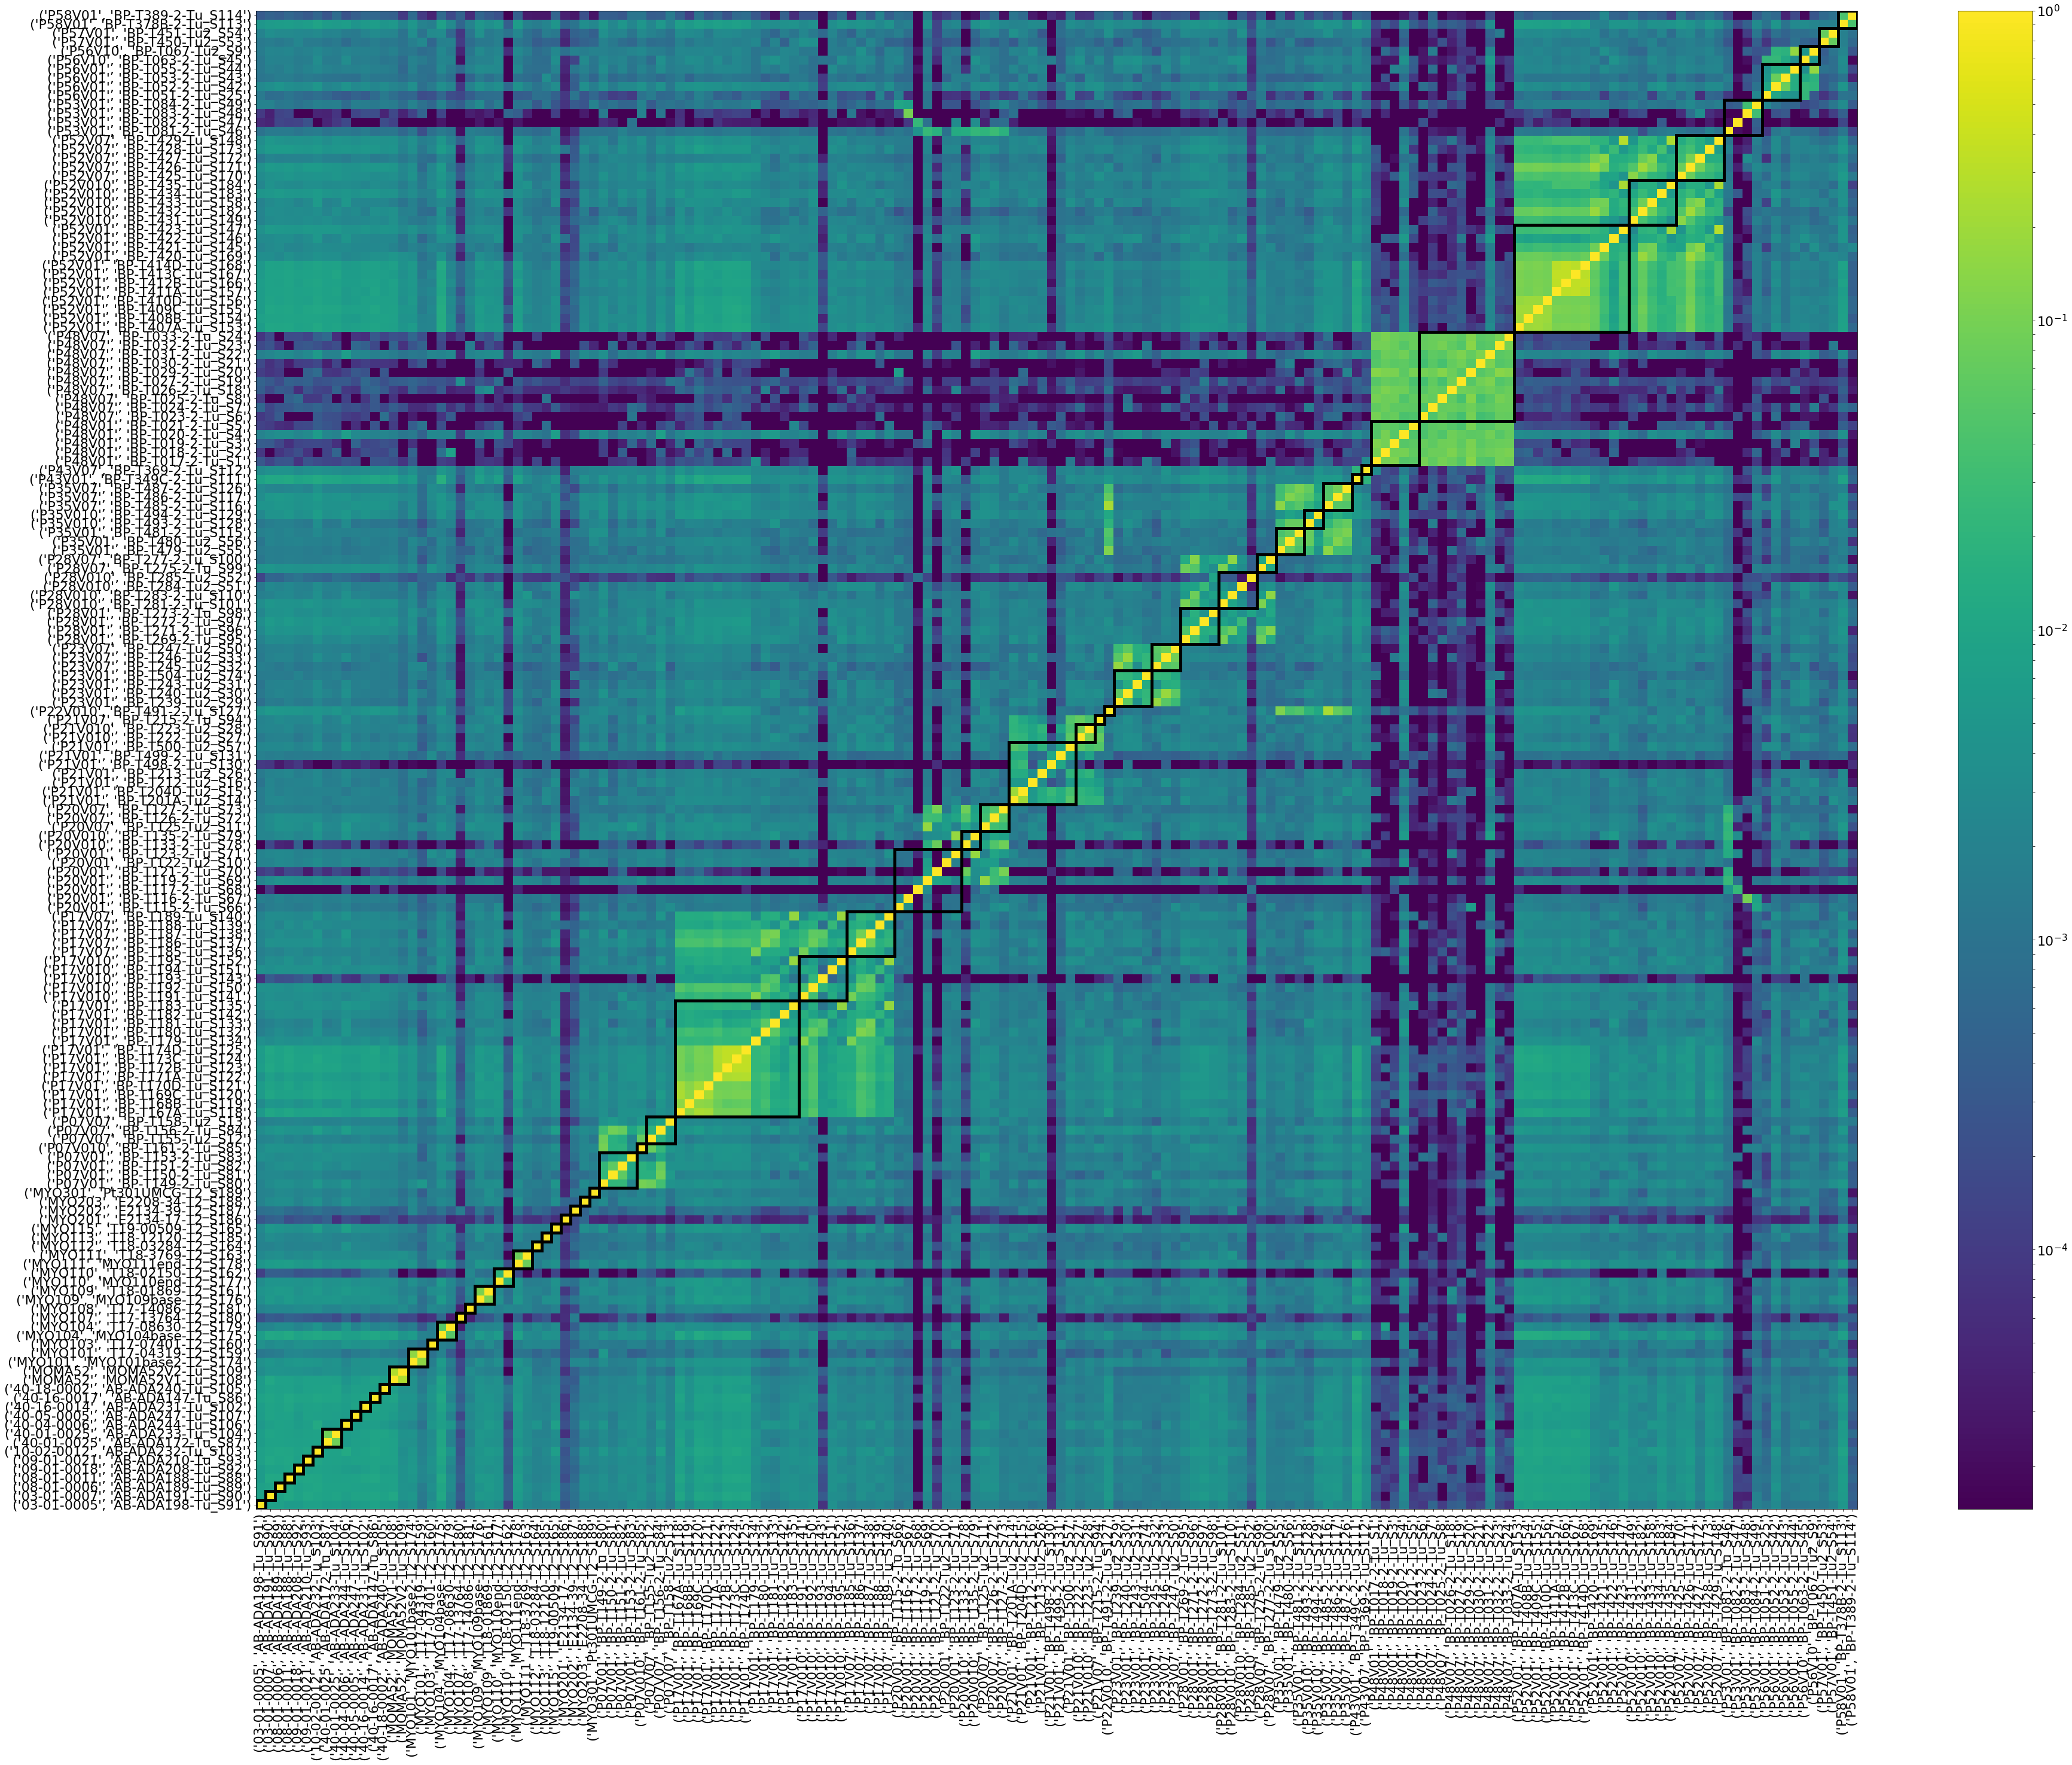

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.055052442373949274 0.06917321599577717
mean diff patient 0.0033370178862976605 0.010758399804756454
threshold 0.046370617105323475


{'boxes': [<matplotlib.lines.Line2D at 0x7fe03f047dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe03efce828>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe03efd64e0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe03efd60b8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe03f047f28>,
  <matplotlib.lines.Line2D at 0x7fe03efde1d0>]}

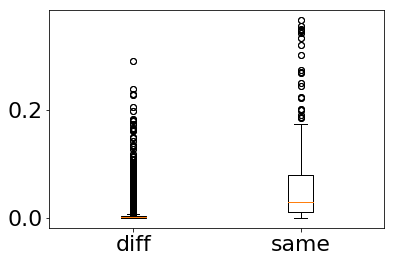

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

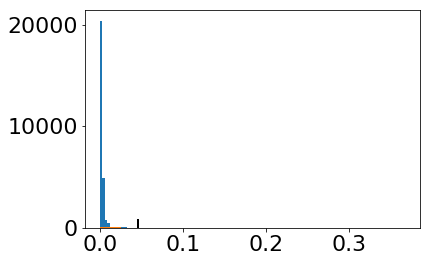

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('P07V01', 'BP-T149-2-Tu_S80') ('P07V010', 'BP-T161-2-Tu_S85') 0.09542706557122926
('P07V01', 'BP-T149-2-Tu_S80') ('P07V07', 'BP-T155-Tu2_S12') 0.0811101596293613
('P07V01', 'BP-T150-2-Tu_S81') ('P07V07', 'BP-T156-2-Tu_S84') 0.09121288068656486
('P07V01', 'BP-T151-2-Tu_S82') ('P07V07', 'BP-T156-2-Tu_S84') 0.07060914746701308
('P07V010', 'BP-T161-2-Tu_S85') ('P07V01', 'BP-T149-2-Tu_S80') 0.09542706557122926
('P07V010', 'BP-T161-2-Tu_S85') ('P07V07', 'BP-T155-Tu2_S12') 0.07633110961197309
('P07V07', 'BP-T155-Tu2_S12') ('P07V01', 'BP-T149-2-Tu_S80') 0.0811101596293613
('P07V07', 'BP-T155-Tu2_S12') ('P07V010', 'BP-T161-2-Tu_S85') 0.07633110961197309
('P07V07', 'BP-T156-2-Tu_S84') ('P07V01', 'BP-T150-2-Tu_S81') 0.09121288068656486
('P07V07', 'BP-T156-2-Tu_S84') ('P07V01', 'BP-T151-2-Tu_S82') 0.07060914746701308
('P17V01', 'BP-T167A-Tu_S118') ('P17V010', 'BP-T192-Tu_S150') 0.05053004453936916
('P17V01', 'BP-T169C-Tu_S120') ('P17V010', 'BP-T192-Tu_S150') 0.04719151815926015
('P17V01', 'BP-T17

('P35V07', 'BP-T486-2-Tu_S117') ('P22V010', 'BP-T491-2-Tu_S127') 0.06875835909579253
('P35V07', 'BP-T486-2-Tu_S117') ('P35V01', 'BP-T480-Tu2_S56') 0.11497445479719548
('P35V07', 'BP-T486-2-Tu_S117') ('P35V01', 'BP-T481-2-Tu_S115') 0.07676713069333696
('P35V07', 'BP-T486-2-Tu_S117') ('P35V010', 'BP-T493-2-Tu_S128') 0.051112082103311196
('P35V07', 'BP-T487-2-Tu_S126') ('P35V01', 'BP-T480-Tu2_S56') 0.06395480620019878
('P35V07', 'BP-T487-2-Tu_S126') ('P35V01', 'BP-T481-2-Tu_S115') 0.10773747116795973
('P35V07', 'BP-T487-2-Tu_S126') ('P35V010', 'BP-T493-2-Tu_S128') 0.068538950183885
('P48V01', 'BP-T017-2-Tu_S1') ('P48V07', 'BP-T023-2-Tu_S6') 0.0968082857746777
('P48V01', 'BP-T017-2-Tu_S1') ('P48V07', 'BP-T024-2-Tu_S7') 0.06559931440146471
('P48V01', 'BP-T017-2-Tu_S1') ('P48V07', 'BP-T025-2-Tu_S8') 0.09775222164140096
('P48V01', 'BP-T017-2-Tu_S1') ('P48V07', 'BP-T026-2-Tu_S18') 0.08003383200296033
('P48V01', 'BP-T017-2-Tu_S1') ('P48V07', 'BP-T027-2-Tu_S19') 0.0533944462632816
('P48V01', 'BP

('P52V01', 'BP-T412B-Tu_S166') ('P52V010', 'BP-T432-Tu_S182') 0.06892773373966343
('P52V01', 'BP-T412B-Tu_S166') ('P52V07', 'BP-T426-Tu_S171') 0.08475965040058264
('P52V01', 'BP-T413C-Tu_S167') ('P52V010', 'BP-T432-Tu_S182') 0.06463711447153175
('P52V01', 'BP-T413C-Tu_S167') ('P52V07', 'BP-T426-Tu_S171') 0.08063032574929274
('P52V01', 'BP-T414D-Tu_S168') ('P52V010', 'BP-T432-Tu_S182') 0.06969352345959812
('P52V01', 'BP-T414D-Tu_S168') ('P52V07', 'BP-T426-Tu_S171') 0.0922700805720219
('P52V01', 'BP-T420-Tu_S169') ('P52V010', 'BP-T432-Tu_S182') 0.18195934211870468
('P52V01', 'BP-T420-Tu_S169') ('P52V010', 'BP-T433-Tu_S158') 0.08899786112994945
('P52V01', 'BP-T420-Tu_S169') ('P52V07', 'BP-T426-Tu_S171') 0.19868887313961725
('P52V01', 'BP-T420-Tu_S169') ('P52V07', 'BP-T427-Tu_S172') 0.08856123935884652
('P52V01', 'BP-T421-Tu_S145') ('P52V010', 'BP-T432-Tu_S182') 0.07715293536138756
('P52V01', 'BP-T421-Tu_S145') ('P52V010', 'BP-T433-Tu_S158') 0.09451489514047218
('P52V01', 'BP-T421-Tu_S145'

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 1.4506945199999066e-05
max value: 1.0
Wrote run49-similarity-TRB_HUMAN-highlighted.pdf to disk


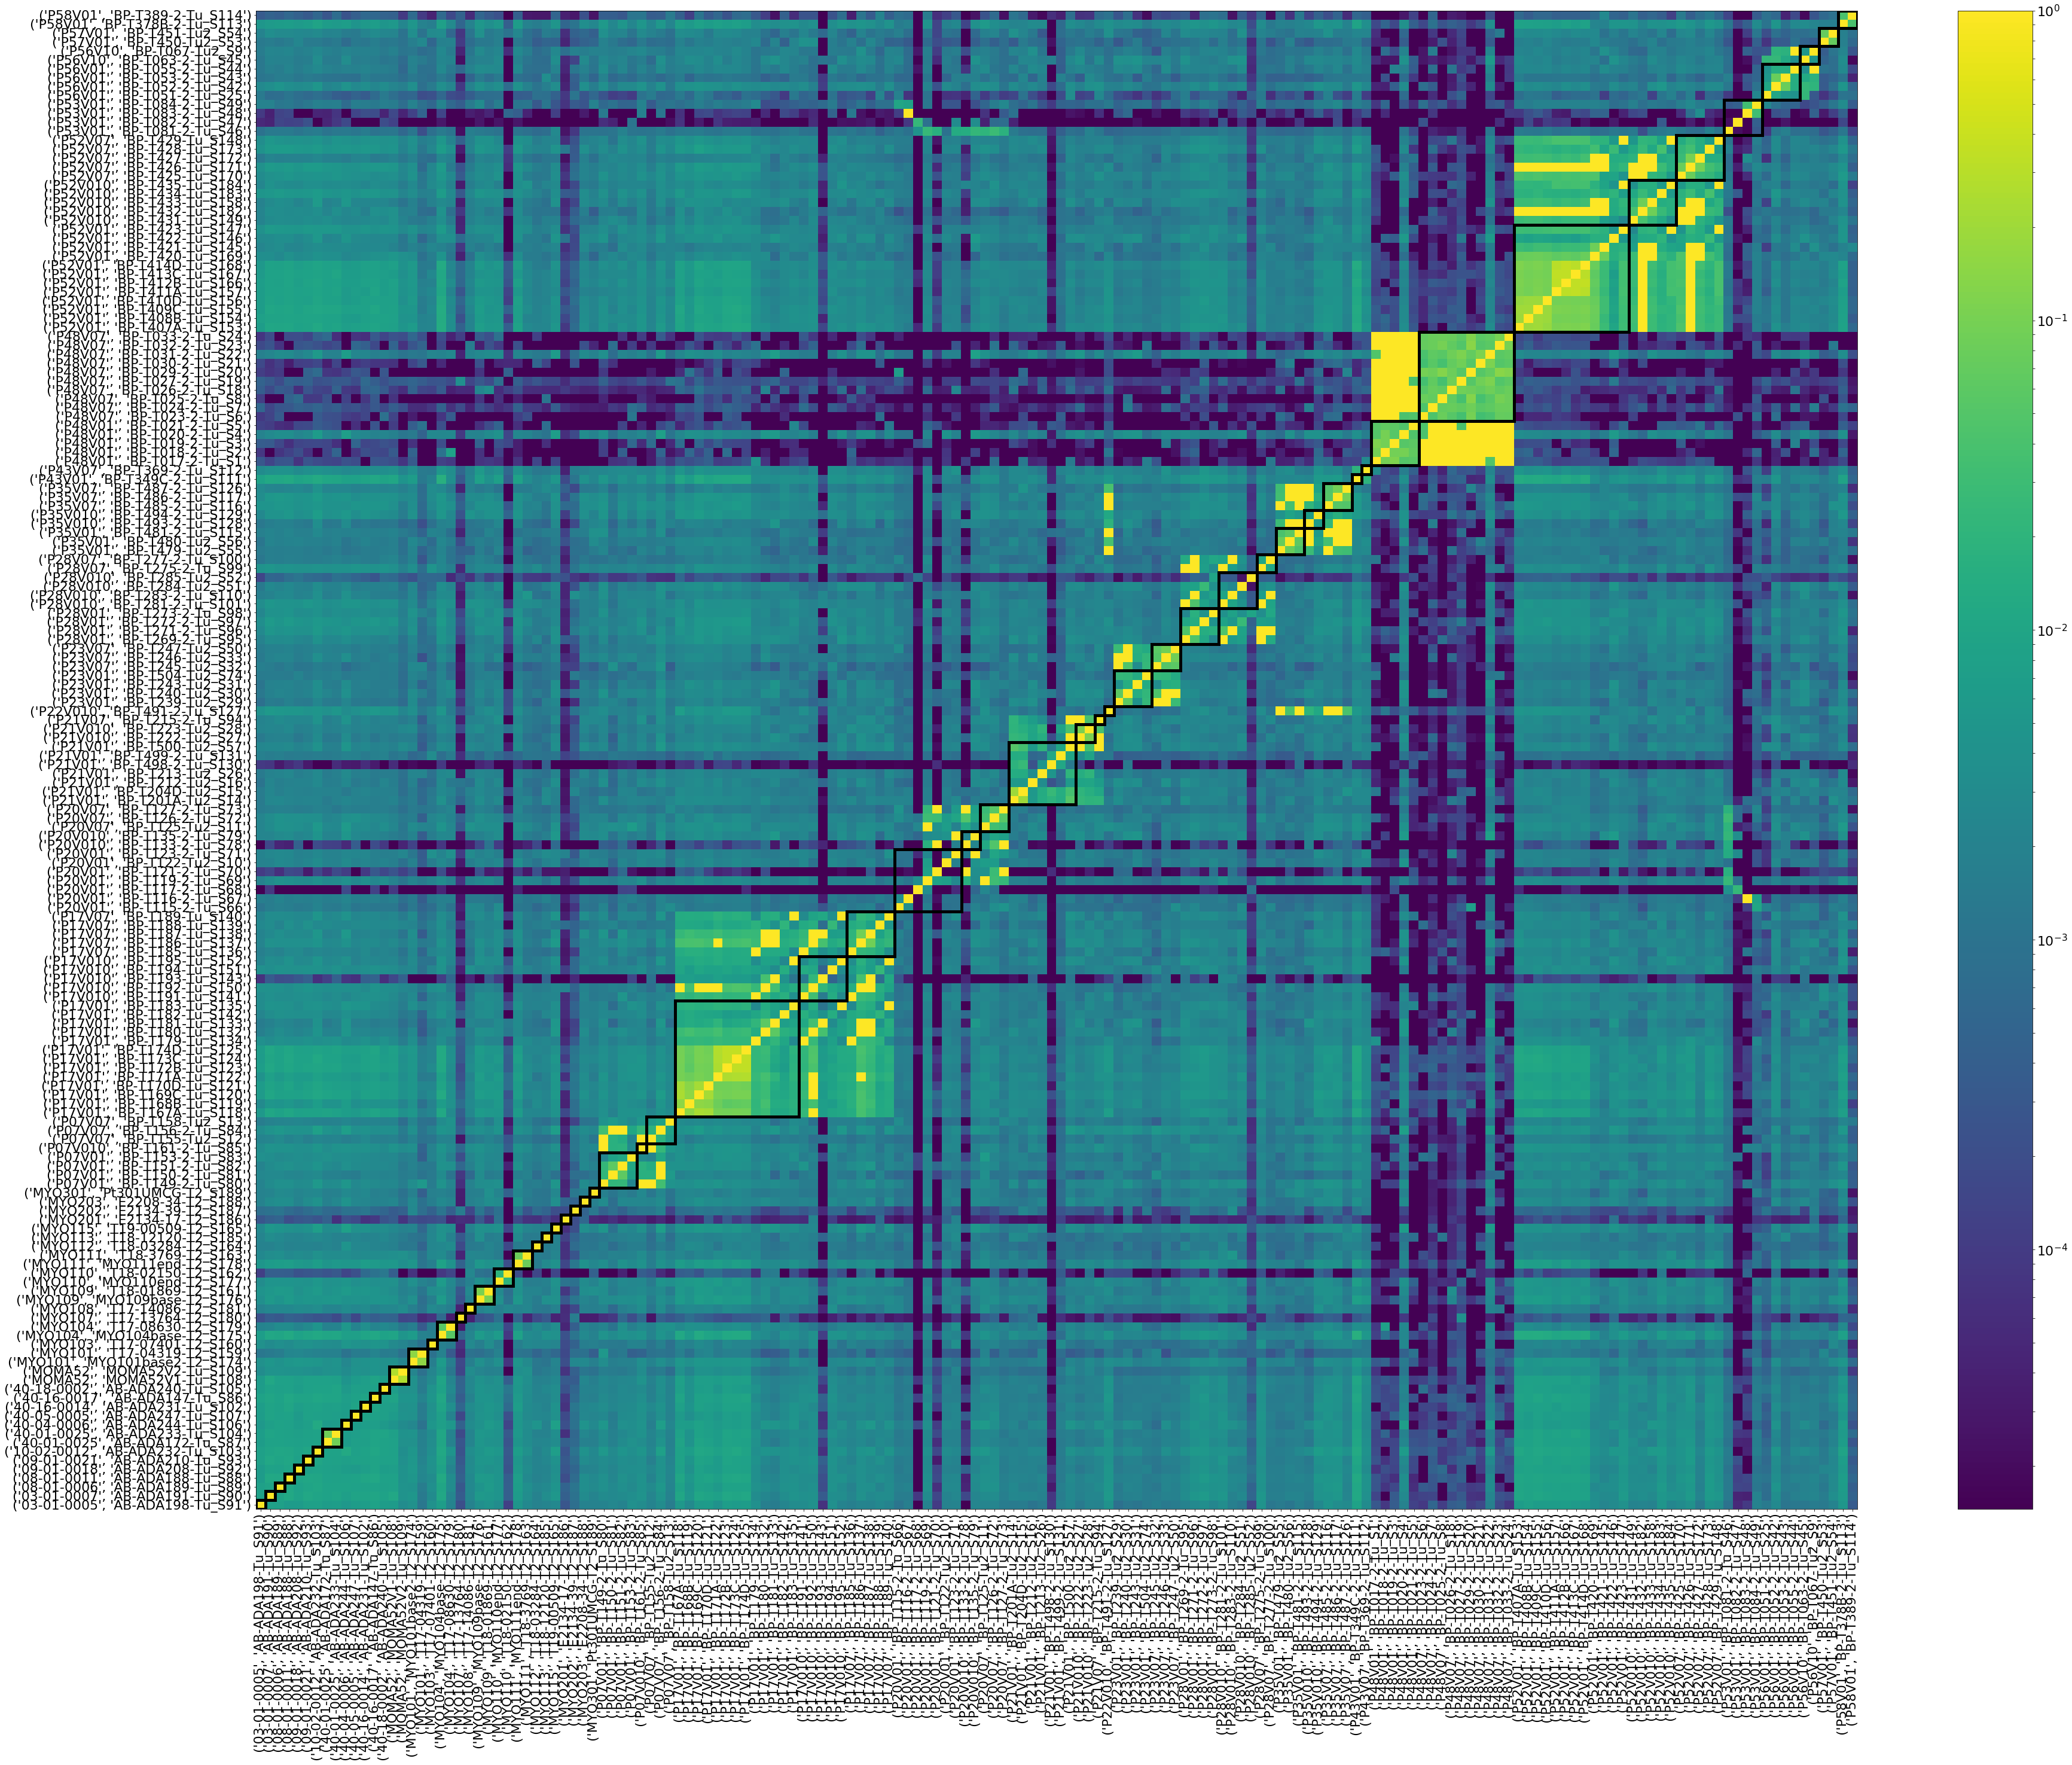

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)